<a href="https://colab.research.google.com/github/Tikhon239/dul_2021/blob/hw12/Homework/hw12/Homework12_semisupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 384 (delta 124), reused 100 (delta 67), pack-reused 163
Receiving objects: 100% (384/384), 55.90 MiB | 26.14 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27640 sha256=3307e92bdb3a8179d2707ab022897bca7b9a16c70f4a5de9fee574f3072aae0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-f_2mhu2q/wheels/55/59/29/0fb1c635652

In [15]:
from typing import Tuple, List, Optional
from tqdm.auto import trange

import numpy as np

import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Normal

from torchvision import transforms

In [3]:
from dul_2021.utils.hw12_utils import *

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1. VAT

Here we will implement [VAT](https://arxiv.org/pdf/1704.03976.pdf).

* Train labeled data with standatd cross-entropy loss

* Use vat regularization for both unlabeled and labeled data

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* ξ= 10 
* lr = 5e-4
* num_epochs = 15



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [5]:
class Classifier(nn.Module):
    def __init__(self, n_classes: int = 4, hidden_dim: int = 128):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU()
        )

        self.linear_block = nn.Sequential(
            nn.Linear(4 * 4 * 128, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, n_classes)
        )

    def forward(self, x, noise=None):
        batch_size = x.shape[0]
        out = self.conv_block(x)
        out = torch.flatten(out, start_dim=1)

        return self.linear_block(out)

In [9]:
class VAT(nn.Module): 
    def __init__(
        self, 
        n_classes: int = 10, 
        eps: float = 10.0,
        alpha: float = 1.0
    ):
        super().__init__()
        self.classifier = Classifier(n_classes)
        self.eps = eps
        self.alpha = alpha

        self.d_dist = Normal(
            torch.zeros((3, 32, 32), device=device),
            torch.ones((3, 32, 32), device=device)
        )

    def forward(self, batch):
        return self.classifier(batch)

    def predict_log_proba(self, batch):
        return F.log_softmax(self(batch), dim=1)

    def get_r(self, batch_size):
        d = self.d_dist.sample((batch_size,))
        d = F.normalize(d, dim=(1,2,3))

        return self.eps * d

    def get_unlabled_loss(self, batch):
        with torch.no_grad():
            log_target = self.predict_log_proba(batch)

        r = self.get_r(batch.shape[0])
        r.requires_grad_()
        log_probabilities = self.predict_log_proba(batch + r)
        adv_distance = F.kl_div(log_probabilities, log_target, log_target=True, reduction="batchmean")
        
        adv_distance.backward()
        r_adv = F.normalize(r.grad, dim=(1,2,3))
        self.zero_grad()

        log_probabilities = self.predict_log_proba(batch + r_adv)
        adv_distance = F.kl_div(log_probabilities, log_target, log_target=True, reduction="batchmean")

        return adv_distance

    def calculate_loss(self, batch, labels):
        mask = labels != -1

        predicition = self(batch[mask])
        labled_loss = F.cross_entropy(predicition, labels[mask], reduction="none")
        batch_accuracy = (torch.argmax(predicition, dim=1) == labels[mask]).sum()

        unlabled_loss = self.get_unlabled_loss(batch)
        loss = labled_loss.mean() + self.alpha * unlabled_loss

        return loss.mean(), batch_accuracy

    def fit(self,
            train_dataloader: DataLoader,
            epochs: int = 20,
            lr: float = 1e-3,
            ) -> Tuple[np.ndarray, np.ndarray]:

        optim = opt.Adam(self.parameters(), lr=lr)

        losses = []
        accuracy_array = []
        for _ in trange(epochs, desc="Tranning"): 
            total = 0
            accuracy = 0
            for batch, labels in train_dataloader:
                batch =  batch.to(device)
                labels = labels.to(device)

                loss, batch_accuracy = self.calculate_loss(batch, labels)

                optim.zero_grad()
                loss.backward()
                optim.step()

                losses.append(loss.item())
                total += (labels != -1).sum().item()
                accuracy += batch_accuracy.item()

            accuracy_array.append(accuracy / total)

        return np.array(losses), np.array(accuracy_array)

In [12]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1
    test_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

    batch_size = 256
    epochs = 5
    lr = 5e-4

    n_classes = 10
    eps = 10.0
    alpha = 1.0
    
    train_dataloader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True
    )

    model = VAT(n_classes=n_classes, eps=eps, alpha=alpha).to(device)
    losses, accuracy_array = model.fit(train_dataloader, epochs=epochs, lr=lr)
    return losses, accuracy_array

Files already downloaded and verified
Files already downloaded and verified


Tranning:   0%|          | 0/5 [00:00<?, ?it/s]

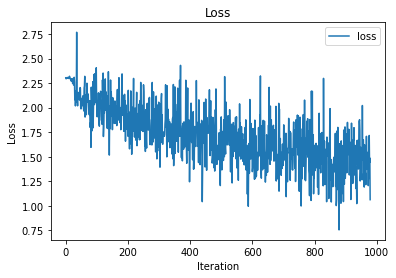

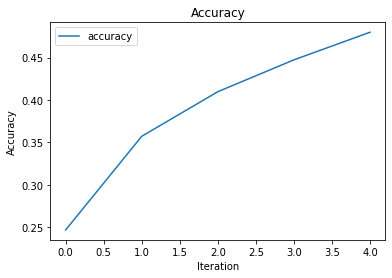

In [13]:
q12_results(q1)

# Question 2. FixMatch

Here we will implement [FixMatch](https://arxiv.org/abs/2001.07685).

* Calculate loss on weakly augmented labeled data with standatd cross-entropy loss

* Calculate loss on strongly augmented unlabeled data with standatd cross-entropy loss with pseudo-lables

* Use SimCLR transformations as strong and RandomHorizontalFlip as weak

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* τ = 0.7 
* λ_u = 10 (weight of unlabeled loss)
* lr = 5e-4
* num_epochs ~ 20 or more



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [17]:
class FixMatch(nn.Module): 
    def __init__(self, n_classes: int, tau: float = 0.7, lambda_u: float = 10.0): 
        super().__init__()

        self.classifier = Classifier(n_classes)
        self.tau = tau
        self.lambda_u = lambda_u

        self.weak_transform = transforms.RandomHorizontalFlip()

        self.strong_transform = transforms.Compose(
            [
             transforms.RandomHorizontalFlip(),
             transforms.RandomResizedCrop(32),
             transforms.RandomApply([transforms.ColorJitter(0.5, 0.5, 0.5, 0.1)], p=0.8),
             transforms.RandomGrayscale(0.2),
            ]
        )

    def forward(self, batch):
        return self.classifier(batch)

    def get_labled_loss(self, batch, labels):
        weak_batch = self.weak_transform(batch)
        labled_loss = F.cross_entropy(self(weak_batch), labels, reduction="none")
        return labled_loss.mean()

    def get_unlabled_loss(self, batch):
        weak_batch = self.weak_transform(batch)
        strong_batch = self.strong_transform(batch)

        with torch.no_grad(): 
            pseudo_labels = F.softmax(self(weak_batch) / self.tau, dim=1)
            target = torch.argmax(pseudo_labels, dim=-1)

        unlabled_loss = F.cross_entropy(self(strong_batch), target, reduction="none")
        return unlabled_loss.mean()

    def calculate_loss(self, batch, labels):
        mask = labels != -1

        predicition = self(batch[mask])
        batch_accuracy = (torch.argmax(predicition, dim=1) == labels[mask]).sum()

        labled_loss = self.get_labled_loss(batch[mask], labels[mask])

        unlabled_loss = self.get_unlabled_loss(batch[~mask])
        loss = labled_loss + self.lambda_u * unlabled_loss

        return loss.mean(), batch_accuracy

    def fit(
        self,
        train_dataloader: DataLoader,
        epochs: int = 20,
        lr: float = 1e-3,
    ) -> Tuple[np.ndarray, np.ndarray]:

        optim = opt.Adam(self.parameters(), lr=lr)

        losses = []
        accuracy_array = []
        for _ in trange(epochs, desc="Tranning"): 
            total = 0
            accuracy = 0
            for batch, labels in train_dataloader:
                batch =  batch.to(device)
                labels = labels.to(device)

                loss, batch_accuracy = self.calculate_loss(batch, labels)

                optim.zero_grad()
                loss.backward()
                optim.step()

                losses.append(loss.item())
                total += (labels != -1).sum().item()
                accuracy += batch_accuracy.item()

            accuracy_array.append(accuracy / total)

        return np.array(losses), np.array(accuracy_array)

In [18]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

    batch_size = 256
    epochs = 1
    lr = 5e-4

    n_classes = 10
    tau = 0.7
    lambda_u = 10.0
    
    train_dataloader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True
    )

    model = FixMatch(n_classes=n_classes, tau=tau, lambda_u=lambda_u).to(device)
    losses, accuracy_array = model.fit(train_dataloader, epochs=epochs, lr=lr)
    return losses, accuracy_array

Files already downloaded and verified
Files already downloaded and verified


Tranning:   0%|          | 0/5 [00:00<?, ?it/s]

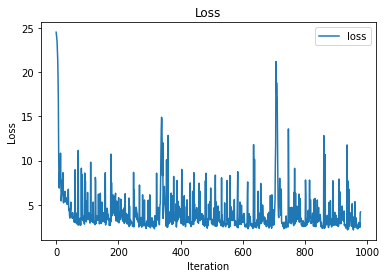

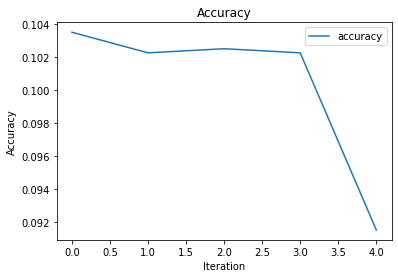

In [20]:
q12_results(q2)

# Bonus

## The probabilistic model

*(this is a short summary of the model presented in ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf))*

In the semi-supervised setting, the generative model is a little more complicated than vanilla VAE. In particular, it incorporates a new variable $y$ that represents the class of a digit $x$.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

## The first part of the objective

Whenever we train a probabilistic model with partial observations, we interpret the unobserved variables as latent variables. Then we marginalize them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds, we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

Using the variational approximation, we will obtain two lower bounds.

First, the ELBO for $\log p(x_i, y_i)$ for the observed variables (this one is similar to ELBO of VAE).

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

Second, the ELBO for $\log p(x_i)$ for the unobserved variables.

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

Finally, the joint lower bound will be

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

We will use reparametrized Monte-Carlo estimates to approximate expectation w.r.t. $z$. To approximate expectaion w.r.t. the discrete variable $y$ we will try three different options.

In [ ]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of binary MNIST images
    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """